# Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from pysheds.grid import Grid
from matplotlib import colors
import seaborn as sns
import warnings
from partition import differentiated_linear_weights, controller_placement_algorithm

warnings.filterwarnings('ignore')
sns.set()
sns.set_palette('husl', 8)

%matplotlib inline

# Generate graph

In [2]:
grid = Grid.from_raster('../data/n30w100_dir', data_name='dir')

In [3]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

# Clip the bounding box to the catchment
grid.clip_to('catch', pad=(1,1,1,1))

# Compute flow distance
grid.accumulation(data='catch', out_name='acc', dirmap=dirmap)
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist', xytype='label')
dist = grid.view('dist', nodata=0, dtype=np.float64)

# Ratio of accumulation within critical range to total accumulation

## Channelized travel time 10 times faster than hillslope

In [4]:
dist_weights = (np.where(grid.view('acc') >= 100, 0.1, 0) 
                + np.where((0 < grid.view('acc')) & (grid.view('acc') <= 100), 1, 0)).ravel()

dists = grid.flow_distance(data='catch', x=x, y=y, weights=dist_weights,
                           dirmap=dirmap, out_name='dist', xytype='label', inplace=False)

weights = differentiated_linear_weights(dists)

acc = grid.accumulation(data='catch', dirmap=dirmap, inplace=False)
wacc = grid.accumulation(data='catch', weights=weights, dirmap=dirmap, inplace=False)

ratio = np.where(grid.mask & acc.astype(bool), wacc / acc, np.nan).ravel()

mask = (dists != 0)
hist, bin_edges = np.histogram(dists[mask].ravel(), range=(0,dists.max()+1e-5), bins=40)

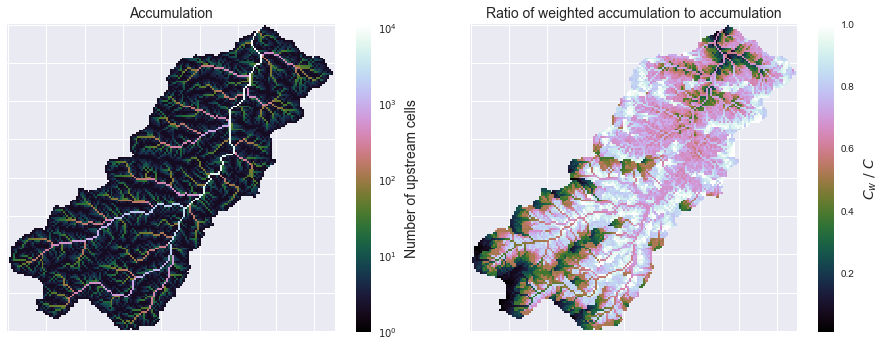

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12.7,4.8))

fig.patch.set_alpha(0)
im0 = ax[0].imshow(np.where(grid.mask, acc + 1, np.nan), cmap='cubehelix', zorder=1, norm=colors.LogNorm(vmin=1, vmax=acc.max()))
im1 = ax[1].imshow(np.where(grid.mask, wacc / acc, np.nan), cmap='cubehelix', zorder=1)
ax[0].set_title('Accumulation', size=14)
ax[1].set_title('Ratio of weighted accumulation to accumulation', size=14)
ax[0].yaxis.set_ticklabels([])
ax[0].xaxis.set_ticklabels([])
ax[1].yaxis.set_ticklabels([])
ax[1].xaxis.set_ticklabels([])
cbar0 = plt.colorbar(im0, ax=ax[0])
cbar0.set_label('Number of upstream cells', size=14, labelpad=8)
cbar1 = plt.colorbar(im1, ax=ax[1])
cbar1.set_label(r'$C_w \ / \ C$', size=14, labelpad=8)
plt.tight_layout()
plt.savefig('../img/acc_and_wacc.png', bbox_inches='tight', dpi=200)